In [1]:
# Modifed code to work with our dataset
# Added data import and handling of our data
# Added data regularization
# updated for multiple inputs


In [2]:
# Import Modules
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import copy 

In [3]:
# Import data
df = pd.read_excel("https://raw.githubusercontent.com/adhicurry/ML_HeatTransfer_Fluids/main/Data_Combined_1_Daksh.xlsx", engine='openpyxl')
# Replace Wall BC to numerical value
pd.set_option('future.no_silent_downcasting', True)
df['WallBC'] = df['WallBC'].replace({'UWT': 0, 'UHF': 1}).astype(float)

# Common commands
#df.describe()
#df.columns
#df[['Rex', 'Nux', 'Pr']]    # Access multiple columns
#df['Figure'].unique()         # List unique ones


In [4]:
# Actual data used for ANN development
#data_subset = df[df['Figure'].isin([2])]   # One figure only
data_subset = df[df['Figure'].isin([2, 3, '4a', '4b', '4c'])]  ## Air only
#data_subset = df[df['Figure'].isin([2, 3, '4a', '4b', '4c', '6a','6b',8])]  ## Air Water and Oil (except Fig 9)


data_subset = data_subset.reset_index(drop=True)
data_subset.info()
data_subset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Figure                       387 non-null    object 
 1   Dataset_Label                387 non-null    object 
 2   data_name_lienhard           387 non-null    object 
 3   Rex                          387 non-null    float64
 4   Nux                          387 non-null    float64
 5   Fluid                        387 non-null    object 
 6   WallBC                       387 non-null    float64
 7   Pr                           387 non-null    float64
 8   Dataset author and year      387 non-null    object 
 9   Dataset range of Rex         387 non-null    object 
 10  Dataset range of ur/uinf     387 non-null    object 
 11  Dataset range dT_bLayer (K)  387 non-null    object 
 12  Rel                          387 non-null    float64
 13  c                   

,Rex,Nux,WallBC,Pr,Rel,c
count,3.870000e+02,387.000000,387.000000,387.00,3.870000e+02,387.000000
mean,9.596948e+05,1155.699408,0.692506,0.71,3.697003e+05,2.588889
std,9.631734e+05,1059.344279,0.462053,0.00,2.993639e+05,1.083188
min,1.094556e+04,35.039791,0.000000,0.71,4.600000e+04,1.600000
25%,2.663972e+05,256.298807,0.000000,0.71,2.350000e+05,2.000000
50%,6.208732e+05,831.279008,1.000000,0.71,3.900000e+05,2.500000
75%,1.279115e+06,1777.013408,1.000000,0.71,3.900000e+05,2.500000
max,4.710209e+06,4460.422368,1.000000,0.71,1.250000e+06,6.000000


## ANN Code

In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set seeds for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

Using device: cpu


In [6]:
# Define input features and output label
x = data_subset[['Rex', 'Pr', 'WallBC', 'c']].values
y = data_subset['Nux'].values

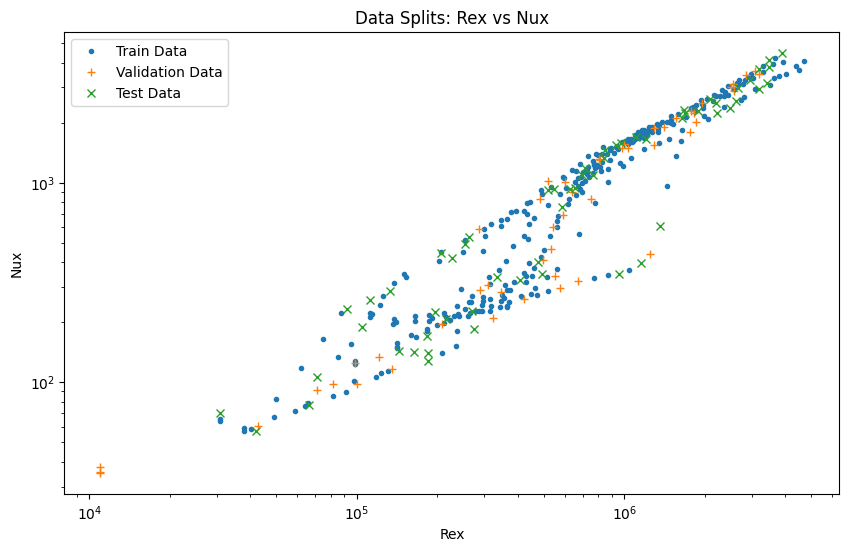

In [7]:
# Split data into train, validation, and test sets
x_train_temp, x_test, y_train_temp, y_test = train_test_split(x, y, test_size=0.15, shuffle=True, random_state=random_seed)
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.15, shuffle=True, random_state=random_seed)
# Initialize scalers
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()

# Fit scalers on training data and transform all sets
x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

# Reshape y values to 2D array for scaling
y_train_2d = y_train.reshape(-1, 1)
y_val_2d = y_val.reshape(-1, 1)
y_test_2d = y_test.reshape(-1, 1)

y_train_scaled = y_scaler.fit_transform(y_train_2d)
y_val_scaled = y_scaler.transform(y_val_2d)
y_test_scaled = y_scaler.transform(y_test_2d)

# Convert to PyTorch Tensors and move to device
x_train = torch.Tensor(x_train_scaled).float().to(device)
y_train = torch.Tensor(y_train_scaled).float().to(device)
x_val = torch.Tensor(x_val_scaled).float().to(device)
y_val = torch.Tensor(y_val_scaled).float().to(device)
x_test = torch.Tensor(x_test_scaled).float().to(device)
y_test = torch.Tensor(y_test_scaled).float().to(device)

# Save scalers for later use (important for making predictions on new data)
import joblib
joblib.dump(x_scaler, 'x_scaler.save')
joblib.dump(y_scaler, 'y_scaler.save')

# Visualize all data splits
plt.figure(figsize=(10, 6))
plt.loglog(x_scaler.inverse_transform(x_train.cpu().numpy())[:, 0], 
           y_scaler.inverse_transform(y_train.cpu().numpy()), '.', label='Train Data')
plt.loglog(x_scaler.inverse_transform(x_val.cpu().numpy())[:, 0], 
           y_scaler.inverse_transform(y_val.cpu().numpy()), '+', label='Validation Data')
plt.loglog(x_scaler.inverse_transform(x_test.cpu().numpy())[:, 0], 
           y_scaler.inverse_transform(y_test.cpu().numpy()), 'x', label='Test Data')
plt.xlabel('Rex')
plt.ylabel('Nux')
plt.title('Data Splits: Rex vs Nux')
plt.legend()
plt.show()

In [8]:
# Define Neural Network

# Model Configuration
config = {
    'input_size': 4,
    'hidden_size': 128,      # Reduced - simpler model might generalize better
    'output_size': 1,
    'learning_rate': 0.001,  # Back to original
    'batch_size': 64,        # Moderate batch size
    'num_epochs': 1000,
    'weight_decay': 0.0001,  # Keep moderate regularization
    'dropout_rate': 0.15     # Slight increase
}

def predict(model, x):
    """Make predictions using the trained model."""
    model.eval()
    with torch.no_grad():
        # Convert input to tensor if it's not already
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x).float().to(device)  # Removed .view(-1, 1) since we have multiple features
        predictions = model(x)
        return predictions.cpu().numpy().ravel()

# Define Neural Network Architecture
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)  # Added batch normalization
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer3(x)
        return x
    
    def save(self, path):
        """Save model parameters."""
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        """Load model parameters."""
        self.load_state_dict(torch.load(path))


# Initialize model using config
model = NN(
    config['input_size'], 
    config['hidden_size'], 
    config['output_size'],
    config['dropout_rate']
).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), 
                      lr=config['learning_rate'],
                      weight_decay=config['weight_decay'])  # Added weight_decay for L2 regularization

# Create data loaders for both training and validation
train_dataset = TensorDataset(x_train, y_train)  
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))

Epoch [10/1000], Train Loss: 0.212877, Val Loss: 0.185326
Epoch [20/1000], Train Loss: 0.211390, Val Loss: 0.135225
Epoch [30/1000], Train Loss: 0.225855, Val Loss: 0.116868
Epoch [40/1000], Train Loss: 0.220980, Val Loss: 0.137176
Epoch [50/1000], Train Loss: 0.175989, Val Loss: 0.130657
Epoch [60/1000], Train Loss: 0.228699, Val Loss: 0.127015
Epoch [70/1000], Train Loss: 0.162695, Val Loss: 0.130970
Epoch [80/1000], Train Loss: 0.174133, Val Loss: 0.115876
Epoch [90/1000], Train Loss: 0.183872, Val Loss: 0.112435
Epoch [100/1000], Train Loss: 0.237262, Val Loss: 0.145924
Epoch [110/1000], Train Loss: 0.202662, Val Loss: 0.140148
Epoch [120/1000], Train Loss: 0.171689, Val Loss: 0.125073
Epoch [130/1000], Train Loss: 0.129858, Val Loss: 0.100710
Epoch [140/1000], Train Loss: 0.171110, Val Loss: 0.104248
Epoch [150/1000], Train Loss: 0.181898, Val Loss: 0.119527
Epoch [160/1000], Train Loss: 0.156365, Val Loss: 0.120624
Early stopping triggered at epoch 163
Best validation loss: 0.098

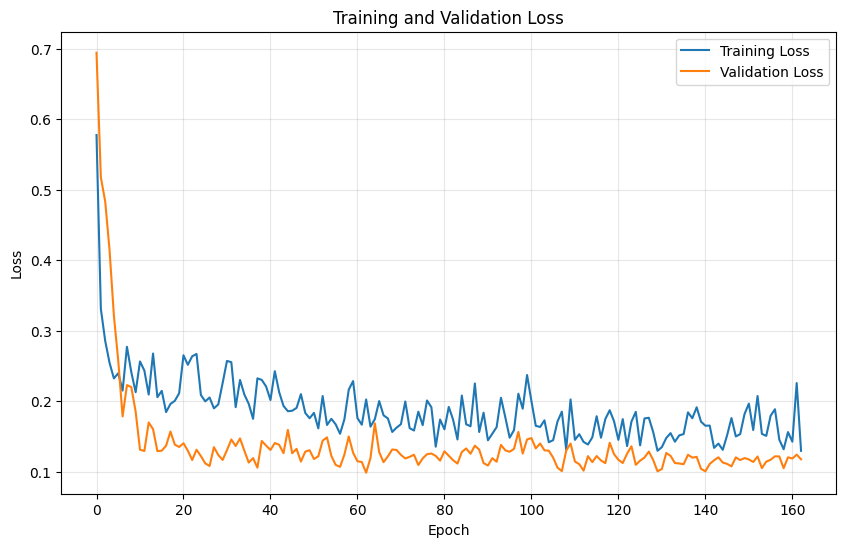

In [9]:
# Define Neural Network Training Parameters
train_losses = []
val_losses = []

# Add variables for tracking best model and early stopping
best_val_loss = float('inf')
best_model = None
patience = 100  # Number of epochs to wait before early stopping
patience_counter = 0

for epoch in range(config['num_epochs']):
    # Training phase
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_batches = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            val_batches += 1
        val_loss = val_loss / val_batches  # Average validation loss
        val_losses.append(val_loss)
        
        # Save the model if it has the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            patience_counter = 0  # Reset counter
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{config["num_epochs"]}], '
              f'Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

print(f'Best validation loss: {best_val_loss:.6f}')

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
#plt.yscale('log')  # Optional: use log scale for better visualization
plt.show()

Test MAE: 121.057167
Average Percentage Error: 18.72%
Minimum Error: 0.11%
Maximum Error: 113.37%
Median Error: 10.90%
68% of the data lies within an error of 20.69%
95% of the data lies within an error of 53.10%
99% of the data lies within an error of 85.98%


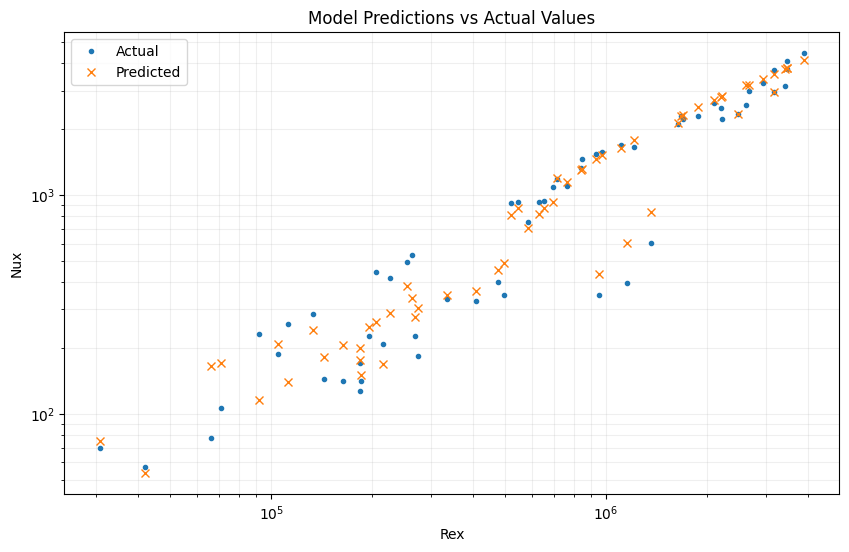

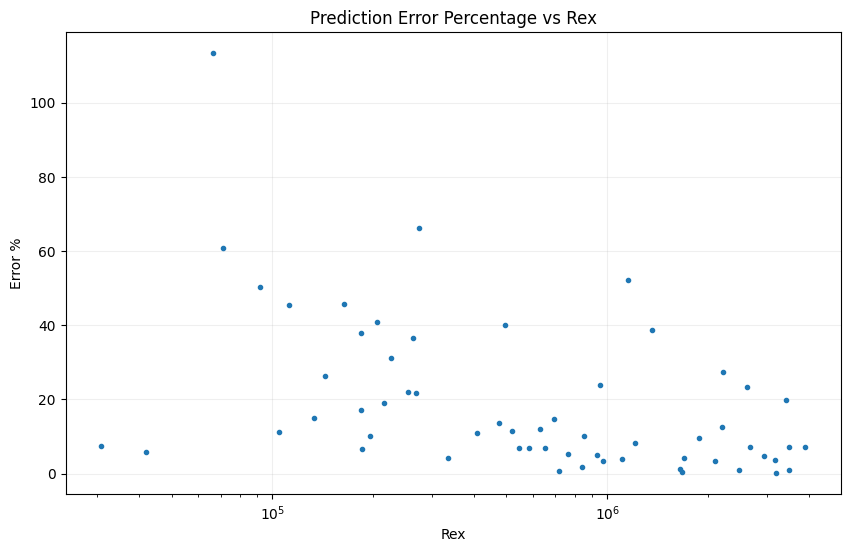

In [10]:
# Save the best model
best_model.save('best_NN_Model.pth')

# Use the best model for final evaluation
model = best_model

# Evaluate Mean Absolute Error of Model on test set
with torch.no_grad():
    model.eval()
    predictions = model(x_test)
    
    # Transform predictions and actual values back to original scale
    predictions_original = y_scaler.inverse_transform(predictions.cpu().numpy())
    y_test_original = y_scaler.inverse_transform(y_test.cpu().numpy())
    
    # Calculate MAE on original scale
    mae = np.mean(np.abs(predictions_original - y_test_original))
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test_original - predictions_original) / y_test_original)) * 100
    
    print(f'Test MAE: {mae:.6f}')
    print(f'Average Percentage Error: {mape:.2f}%')

    # Calculate statistics about the error distribution
    error_percentages = 100 * np.abs(predictions_original - y_test_original) / y_test_original
    print(f'Minimum Error: {np.min(error_percentages):.2f}%')
    print(f'Maximum Error: {np.max(error_percentages):.2f}%')
    print(f'Median Error: {np.median(error_percentages):.2f}%')

    # Calculate percentile statistics
    percentiles = [68, 95, 99]  # Can modify these percentiles as needed
    for p in percentiles:
        threshold = np.percentile(error_percentages, p)
        print(f'{p}% of the data lies within an error of {threshold:.2f}%')

# Plot predicted value vs actual value
plt.figure(figsize=(10, 6))
# Transform data back to original scale for plotting
actual_Rex = x_scaler.inverse_transform(x_test.cpu().numpy())[:, 0]  # Get Rex values and inverse transform
actual_Nux = y_scaler.inverse_transform(y_test.cpu().numpy()).ravel()
predicted_Nux = y_scaler.inverse_transform(predictions.cpu().numpy()).ravel()

plt.loglog(actual_Rex, actual_Nux, '.', label='Actual')
plt.loglog(actual_Rex, predicted_Nux, 'x', label='Predicted')
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Rex')
plt.ylabel('Nux')
plt.grid(True, which="both", ls="-", alpha=0.2)  # Add grid for better readability
plt.legend()
plt.show()

# Optional: Add error percentage plot
plt.figure(figsize=(10, 6))
error_percentage = 100 * np.abs(predicted_Nux - actual_Nux) / actual_Nux
plt.semilogx(actual_Rex, error_percentage, '.')
plt.title('Prediction Error Percentage vs Rex')
plt.xlabel('Rex')
plt.ylabel('Error %')
plt.grid(True, alpha=0.2)
plt.show()

In [11]:
### OPTIONAL 
## Example of how to use the model for new data
# new_x = np.linspace(-np.pi, np.pi, 100)  # New data points
# predictions = predict(model, new_x)

## Example of how to load and use a saved model
# new_model = NN(config['input_size'], config['hidden_size'], config['output_size']).to(device)
# new_model.load('best_sine_model.pth')
# predictions_from_loaded = predict(new_model, new_x)